# Import Data

In [1]:
# Import packages
import numpy as np
import pandas as pd
from numpy import loadtxt
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import ggplot as ggplot
color = sns.color_palette()


# Set parameters
path = "C:/Users/nthor/Documents/GitHub/Predicting_Property_Value_Zillow/data/"
loc_properties = "properties_2016.csv"
loc_train = "train_2016_v2.csv"
trainingsize = .8

C:\Users\nthor\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.
C:\Users\nthor\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\nthor\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Users\nthor\Anaconda3\lib\site-packages\statsmode

In [2]:
# Import files
transactions = pd.read_csv(path + loc_train, delimiter=',', parse_dates=["transactiondate"])
properties = pd.read_csv(path + loc_properties, delimiter=',')

C:\Users\nthor\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Examine properties set
properties.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [4]:
# Examine list of sold homes
transactions.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [5]:
# Merge datasets
merged = pd.merge(properties, transactions, on=['parcelid','parcelid'])
# Fix latitude and longitude coordinates
merged.latitude = merged.latitude / 1e6
merged.longitude = merged.longitude / 1e6


# Data Exploration

### Logerror

Let's start by examining the value that we're responsible for predicting.

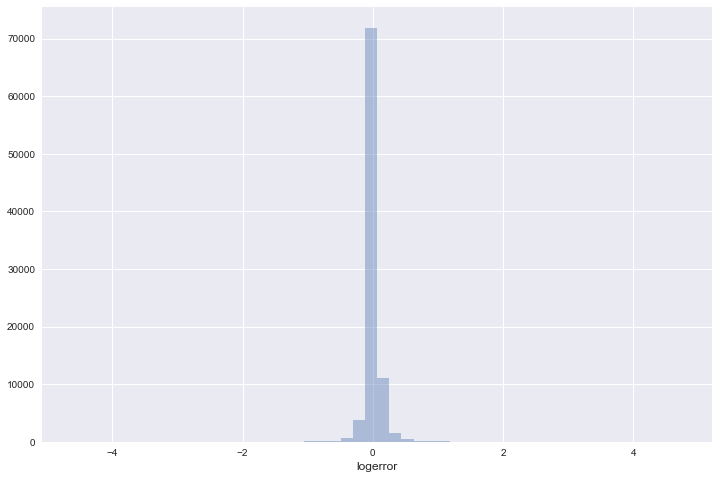

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(merged.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

In [7]:
# Examine outliers
merged.logerror.describe()

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64

We have a few major outliers on either end of the spectrum. In general, the Zestimate seems to overshoot the actual sales price.

### Time Variables
Next, we explore how our transactions vary across time.

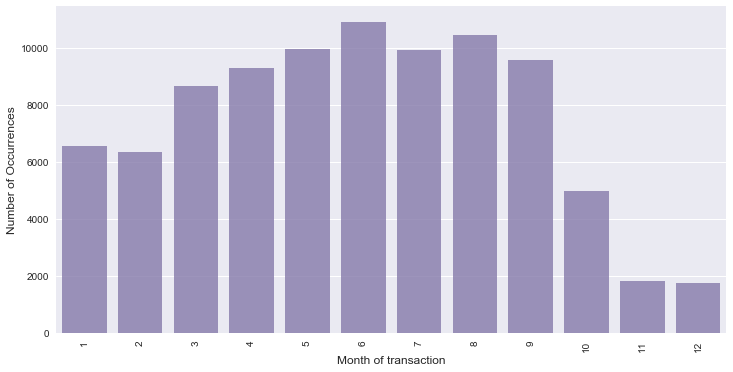

In [8]:
# Create month variable and accurate prediction indicator
merged['transaction_month'] = merged['transactiondate'].dt.month
merged['accurate_price'] = '0'
merged['accurate_price'].loc[(merged.logerror.values == 0)] == '1'



# Plot results
cnt_srs = merged.transaction_month.value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

Unsurprisingly, most real estate activity occurs during the spring and summer.

### Geographic Area

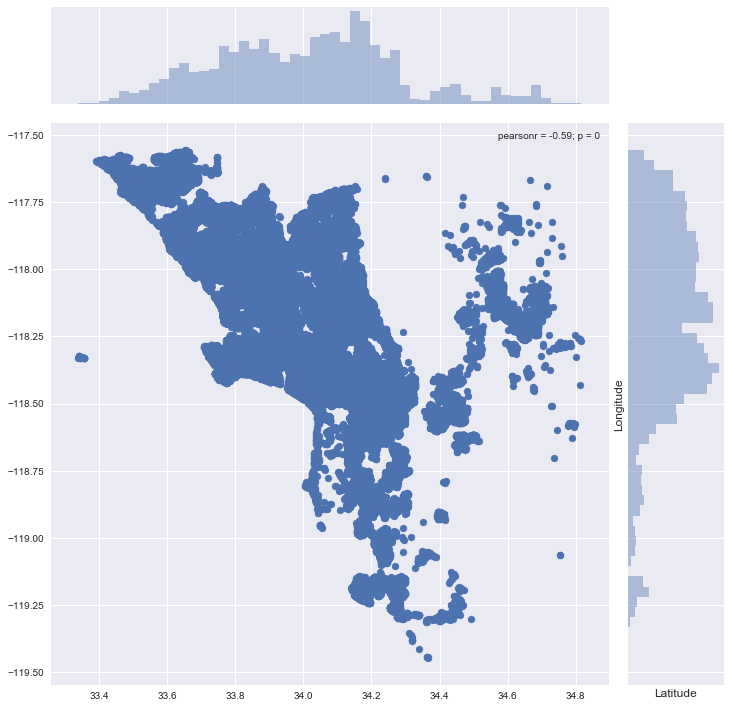

In [9]:
plt.figure(figsize=(12,12))
sns.jointplot(x=merged.latitude.values, y=merged.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

Sales made across three regions in California. Any pattern by region?

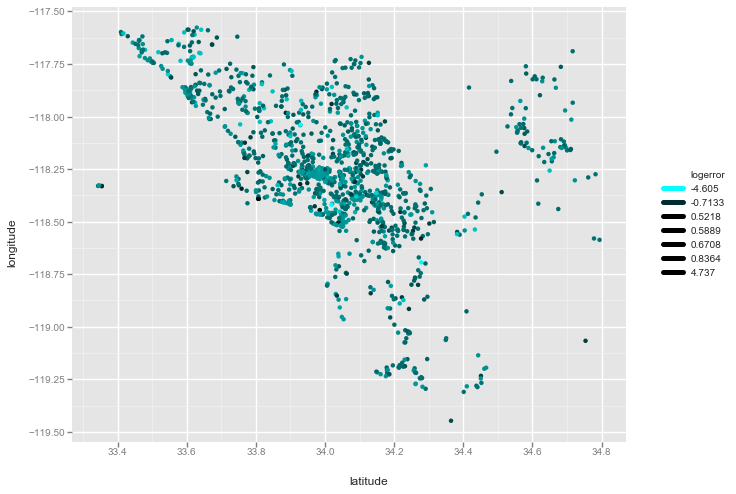

<ggplot: (154804309070)>

In [10]:
# Filter map by logerror to better reveal clusters
from ggplot import * 
ggplot(aes(x='latitude', y='longitude', color='logerror'), data=merged[abs(merged.logerror.values) > .5]) + \
    geom_point() + \
    scale_color_gradient(low = 'aqua', high = 'black')

### Geospatial Clustering

In [11]:
# Filter outliers >1 std. dev. away and create array for plotting
filtered_pred = merged[abs(merged.logerror.values) > np.std(merged.logerror.values)]
lat_long = np.transpose(np.array([filtered_pred.latitude, filtered_pred.longitude]))
lat = np.array([filtered_pred.latitude])
long = np.array([filtered_pred.longitude])

# Take average for folium map
avg_lat = sum(merged.latitude.values)/len(merged.latitude.values)
avg_long = sum(merged.longitude.values)/len(merged.longitude.values)

In [12]:
# Cluster by coordinates
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN
from geopy.distance import vincenty

dbscan = DBSCAN(eps=5/6371., min_samples=5, algorithm='ball_tree', metric='haversine') # 50 meters
dbscan.fit(np.radians(lat_long))

cluster_labels = dbscan.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([lat_long[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 11


## To DO: Finish clustering

distance_matrix = [0] * len(merged)

for i in list(range(0, len(merged)-1)):
    distance_matrix[i] = vincenty((lat[0, i], long[0, i]), (lat[0, i+1], long[0, i+1])).m
    
np.array([distance_matrix])


import folium
map_1 = folium.Map(location=[avg_lat, avg_long], tiles = "Mapbox Bright", zoom_start = 9)

folium.Marker([merged.latitude[3], merged.longitude[2]]).add_to(map_1)

import folium
map_1 = folium.Map(location=[avg_lat, avg_long], tiles = "Mapbox Bright")

#fol.Marker([45.5244, -122.6699],
 #             popup='The Waterfront'
  #           ).add_to(map_2)

for i in list(range(0, len(merged))):
    folium.CircleMarker([merged.latitude[i], merged.longitude[i]],
                    radius=50,
                    color='#3186cc',
                    fill_color='#3186cc',
                   ).add_to(map_1)
map_1

There does seem to be a few clusters that would be worth exploring further.

### Missing Values
Let's figure out how many missing values we're dealing with.

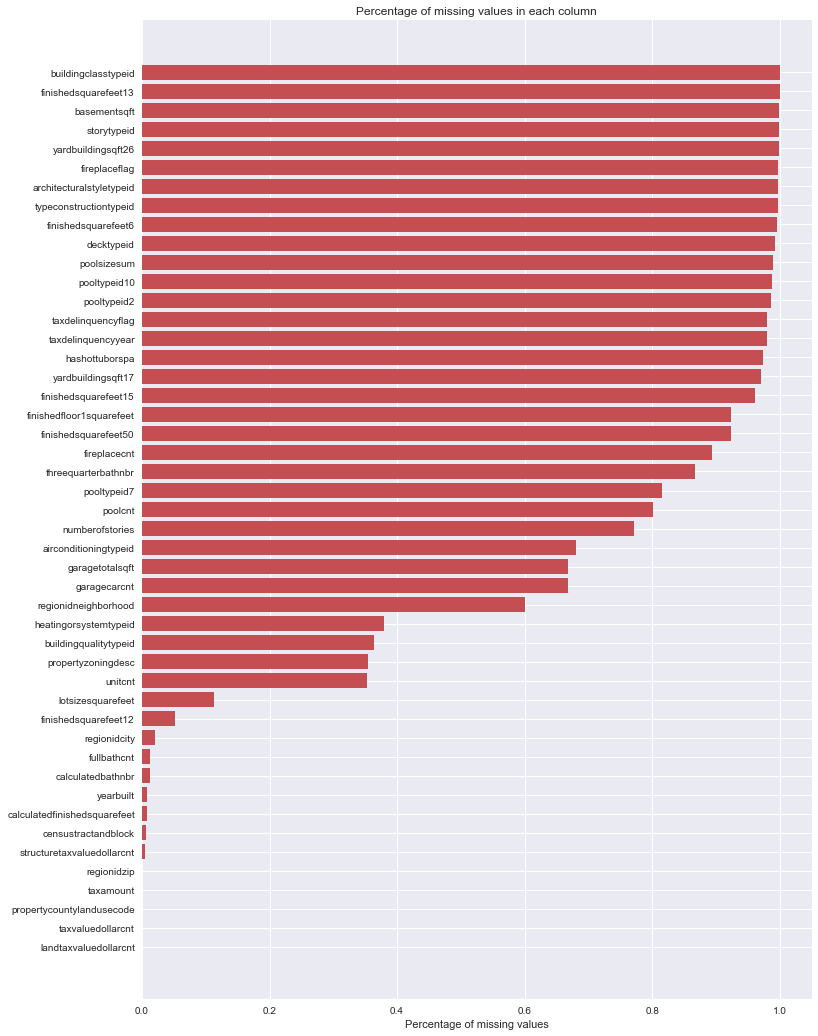

In [13]:
missing_df = merged.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df['missing_ratio'] = missing_df['missing_count'] / merged.shape[0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_ratio.values, color=color[2])
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Percentage of missing values")
ax.set_title("Percentage of missing values in each column")
plt.show()

Several of our columns are almost entirely made up of 'nulls'; we'll have to keep this in mind when performing feature selection.

### Correlation Analysis

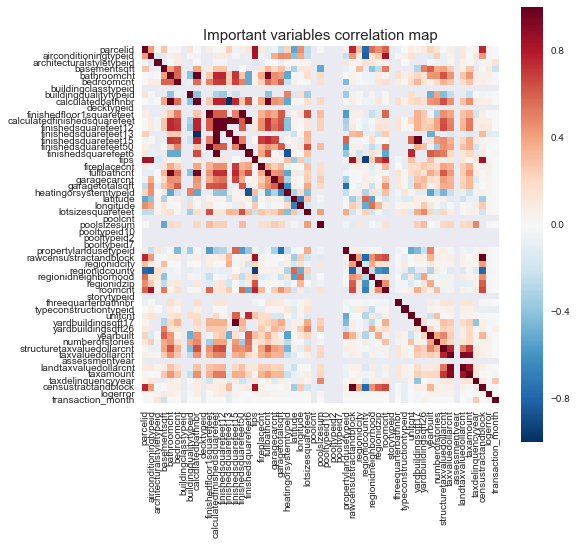

In [14]:
# Define heat map
corrmat = merged.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True, annot = False)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

Which x-variables are highly correlated with our predicted values?

In [15]:
corrmat.logerror[corrmat.logerror.values > .025]

C:\Users\nthor\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


parcelid                        0.027544
architecturalstyletypeid        0.044570
basementsqft                    0.098648
bathroomcnt                     0.066674
bedroomcnt                      0.041665
calculatedbathnbr               0.067080
calculatedfinishedsquarefeet    0.074351
finishedsquarefeet12            0.078631
finishedsquarefeet15            0.039680
fireplacecnt                    0.050074
fullbathcnt                     0.060977
garagecarcnt                    0.030169
garagetotalsqft                 0.028387
yearbuilt                       0.044450
numberofstories                 0.054582
structuretaxvaluedollarcnt      0.034373
taxvaluedollarcnt               0.031599
logerror                        1.000000
transaction_month               0.026840
Name: logerror, dtype: float64

In plain English, the following variables appear to be highly correlated with mistaken Zestimates:
* House / basement size
* Number of bathrooms
* Number of bedrooms
* Number of fireplaces
* Number of garage spaces
* Number of stories
* Newer apartments
* Taxes paid

In short, Zillow's estimates seem to inappropriately price large / lavish / new homes. Basement size appears to be particularly correlated to logerror; perhaps the algorithm doesn't accurately value large basements?

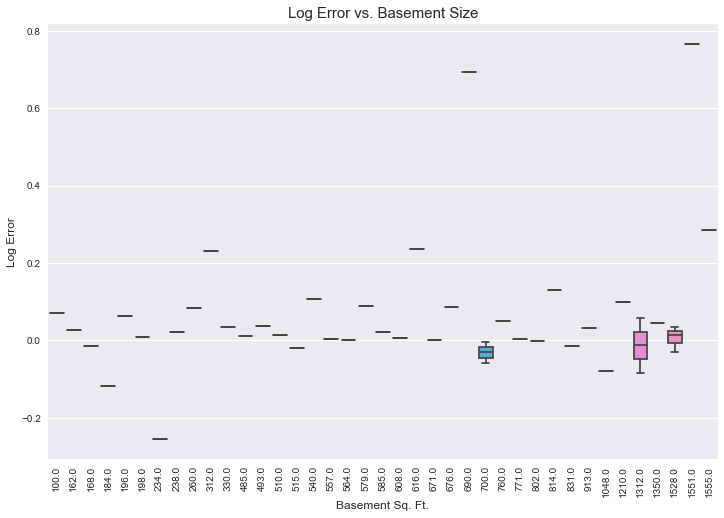

In [16]:
plt.figure(figsize=(12,8))
sns.boxplot(x="basementsqft", y="logerror", data = merged)
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Basement Sq. Ft.', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Log Error vs. Basement Size", fontsize=15)
plt.show()

We see a slight positive trend, with a greater degree of logerror variance near the end of the x-axis.

C:\Users\nthor\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


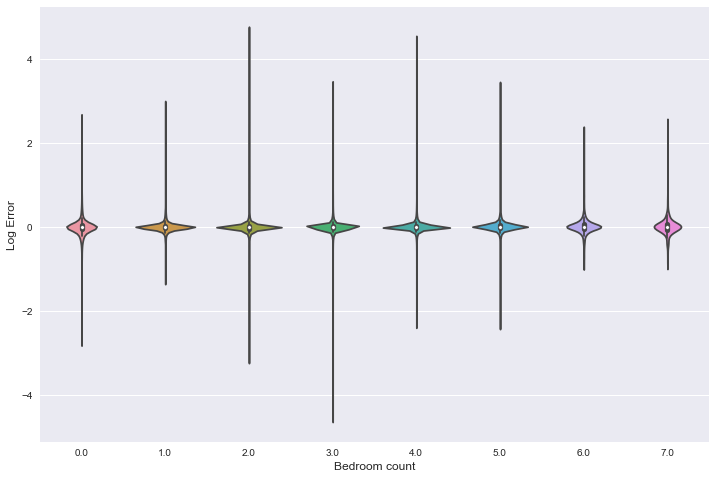

In [17]:
merged['bedroomcnt'].loc[merged['bedroomcnt']>7] = 7
plt.figure(figsize=(12,8))
sns.violinplot(x='bedroomcnt', y='logerror', data=merged)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

Densely populated at zero, with slightly more spread at either end of the x-axis; studios and large mansions may be harder to accurately predict sales price.

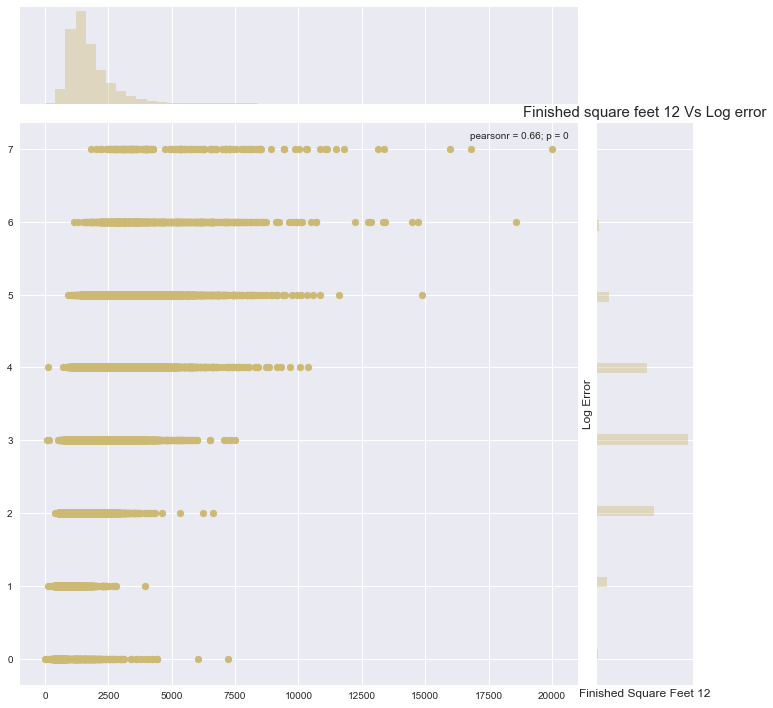

In [18]:
plt.figure(figsize=(12,12))
sns.jointplot(x=merged.finishedsquarefeet12.values, y=merged.bedroomcnt.values, size=10, color=color[4])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

Many of our exogeneous variables are likely to be correlated (as illustrated above), which we'll have to keep in mind as we select our features.

# Data Cleaning

In [19]:
# split data into X and y
X = merged.drop(['parcelid', 'logerror', 'transactiondate', 'transaction_month', 'accurate_price', 'propertycountylandusecode', 'propertyzoningdesc'], axis=1).fillna(0)
y = merged['logerror']

# convert taxdelinquencyflag 'Y's into 1's
X.iloc[X[X['taxdelinquencyflag'] == 'Y'].index, X.columns.get_loc('taxdelinquencyflag')] = 1

# convert X to float
X = X.apply(pd.to_numeric)

# Split into test / training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

TODO: Remove nulls when testing other model types

# Feature Engineering

In [20]:
import sklearn.linear_model as sklm

sklm.ElasticNetCV()

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [21]:
#from sklearn.feature_selection import SelectFromModel
#model = SelectFromModel(clf, prefit=True)
#X_new = model.transform(X)

TODO: Create new features after exploring initial Random Forest results.

# Feature Selection

In [22]:
# Scale features
scaler = StandardScaler()

X_s = scaler.fit_transform(X)
y_s = scaler.fit_transform(y)

C:\Users\nthor\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\nthor\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


### Recursive Feature Selection

In [27]:
from sklearn import preprocessing
from sklearn import utils

# Call label encoder on continuous y-variable
lab_enc = preprocessing.LabelEncoder()
y_encoded = lab_enc.fit_transform(y_s)

In [24]:
# Feature Extraction with RFE
#from sklearn.feature_selection import RFE
#from sklearn.linear_model import LogisticRegression
#model = LogisticRegression()
#rfe = RFE(model, 3)
#fit = rfe.fit(X, y_encoded)
#print("Num Features: %d") % fit.n_features_
#print("Selected Features: %s") % fit.support_
#print("Feature Ranking: %s") % fit.ranking_

### Principle Component Analysis

In [30]:
from sklearn.decomposition import PCA

# Extract features
pca = PCA(n_components=3)
fit = pca.fit(X_s)
# Summarize components
print("Explained Variance: ", fit.explained_variance_ratio_)

Explained Variance:  [ 0.16196853  0.12054612  0.07030182]


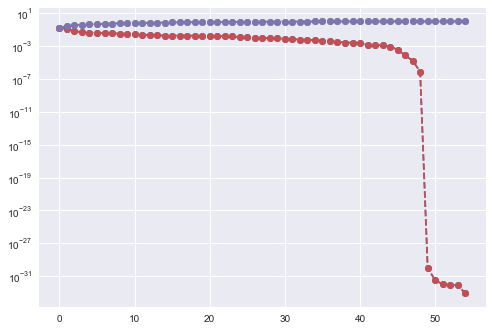

In [32]:
# Visualize results
pca_viz = PCA().fit(X_s);

plt.semilogy(pca_viz.explained_variance_ratio_, '--o');
plt.semilogy(pca_viz.explained_variance_ratio_.cumsum(), '--o');
plt.show()


### ElasticNet Lasso (requires troubleshooting)

Computing regularization path using the elastic net...
Computing regularization path using the positive elastic net...


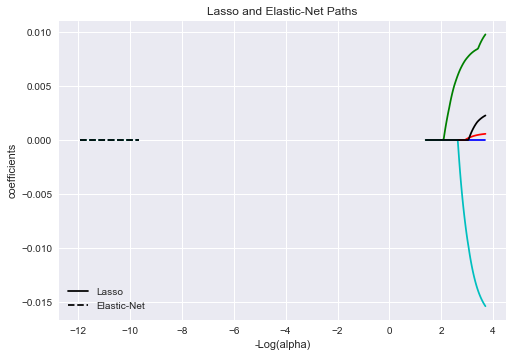

In [38]:
# Import packages and set model
from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets
eps = 5e-3 # length of the path

alphas_lasso, coefs_lasso, _ = lasso_path(X_s, y_s, eps, fit_intercept=False)

alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(X_s,
                                                            y_s,
                                                            eps,
                                                            positive=True, # forces coefficients to be positive
                                                            fit_intercept=False)
print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, fit_intercept=False)

print("Computing regularization path using the positive elastic net...")
alphas_positive_enet, coefs_positive_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, positive=True, fit_intercept=False)

# Display results
import itertools

plt.figure(1)
ax = plt.gca()

colors = (['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')
plt.show()


### Tree-Based Feature Importance (LightGBM)
Quick and dirty way to identify features before we build a cross-validated model.

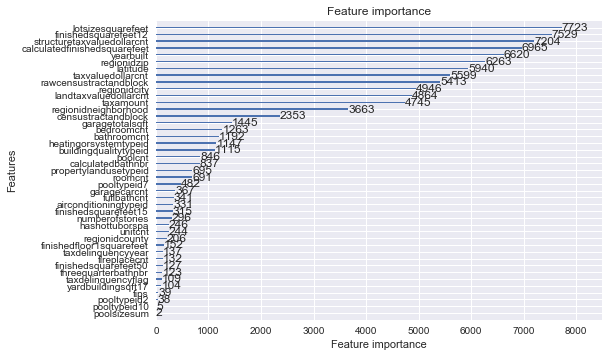

In [43]:
# Convert dataset
d_train = lgb.Dataset(X_train, label=y_train)

# Train model
clf = lgb.train(params, d_train, 1000)

# Plot importance
lgb.plot_importance(clf)
plt.show()

# Model Building

### LightGBM

In [40]:
# Convert dataset
d_train = lgb.Dataset(X_train, label=y_train)

# Set parameters
params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.0021 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['sub_feature'] = 0.5      # feature_fraction -- OK, back to .5, but maybe later increase this
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

# Create dictionary to capture evaluation
eval_result = {}
lgb.record_evaluation(eval_result)
lgb.print_evaluation()


# Train model
clf = lgb.train(params, 
               d_train,
               500)

# Build model with 10-fold CV
clf_cv = lgb.cv(params, 
                d_train, 
                500, 
                nfold = 10, 
                early_stopping_rounds = 25,
                stratified = True)


# Compare error terms

C:\Users\nthor\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


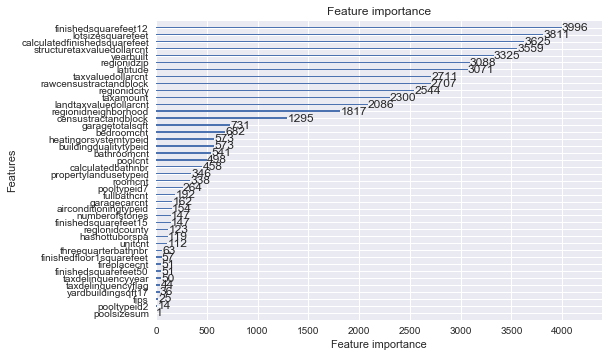

In [41]:
# Compare feature importance
lgb.plot_importance(clf)
plt.show()

In [42]:
# Calculate error terms
ypred = clf.predict(X_train, num_iteration=clf.best_iteration)
ypred

array([ 0.01353791,  0.00558417,  0.04026726, ...,  0.01935574,
        0.01670222,  0.01280902])

### Stratified K-Fold Cross-Validation of XGBoost

In [44]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

params = {}
params['eta'] = 0.02
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['silent'] = 1

watchlist = [(d_train, 'train'), (d_test, 'valid')]
clf_xgb = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=500)

[0]	train-mae:0.487279	valid-mae:0.487294
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
Stopping. Best iteration:
[349]	train-mae:0.067492	valid-mae:0.068165



In [45]:
clf_xgb.get_fscore()

{'airconditioningtypeid': 182,
 'architecturalstyletypeid': 2,
 'basementsqft': 33,
 'bathroomcnt': 278,
 'bedroomcnt': 155,
 'buildingclasstypeid': 64,
 'buildingqualitytypeid': 80,
 'calculatedfinishedsquarefeet': 465,
 'censustractandblock': 91,
 'decktypeid': 11,
 'finishedfloor1squarefeet': 87,
 'finishedsquarefeet12': 171,
 'finishedsquarefeet15': 175,
 'finishedsquarefeet50': 34,
 'finishedsquarefeet6': 73,
 'fips': 13,
 'fireplacecnt': 7,
 'fullbathcnt': 4,
 'garagecarcnt': 2,
 'garagetotalsqft': 28,
 'hashottuborspa': 18,
 'heatingorsystemtypeid': 70,
 'landtaxvaluedollarcnt': 193,
 'latitude': 339,
 'longitude': 340,
 'lotsizesquarefeet': 387,
 'numberofstories': 4,
 'poolcnt': 64,
 'poolsizesum': 6,
 'propertylandusetypeid': 40,
 'rawcensustractandblock': 187,
 'regionidcity': 106,
 'regionidneighborhood': 31,
 'regionidzip': 276,
 'roomcnt': 11,
 'structuretaxvaluedollarcnt': 328,
 'taxamount': 474,
 'taxdelinquencyflag': 3,
 'taxdelinquencyyear': 65,
 'taxvaluedollarcnt': 

In [ ]:
# CV model
model = xgb.XGBClassifier()
kfold = StratifiedKFold(n_splits=5, random_state=7)
results = cross_val_score(model, X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


C:\Users\nthor\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


### Stratified K-Fold NN in Keras

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=seed)
# create model
model = Sequential()
model.add(Dense(12, 55, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=150, batch_size=10)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy

optimizer = 'adam'
init = 'glorot_uniform' #'normal', 'uniform']
epochs = 150
batches = 20
 
# Function to create model, required for KerasClassifier
def create_model(optimizer='rmsprop', init='glorot_uniform'):
    # create model
    model = Sequential()
    model.add(Dense(12, input_shape = 55, kernel_initializer=init, activation='relu'))
    model.add(Dense(8, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
 
model.fit(X_train, y_train, validation_date = (X_test, y_test), epochs = epochs, batch_size = batches)




# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#	print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Select classifier
xgb = xgboost.XGBClassifier()
xgb.fit(X, y)  # works fine

# Making a pipeline with this classifier and a scaler:
xgb_pipe = Pipeline([('scaler', MinMaxScaler()), ('classifier', XGBClassifier())])

predicted = cross_val_predict(clf, X_test, y_test, cv=10)
metrics.accuracy_score(y_test, predicted) 
 
pipe.fit(X, y)  # works fine